In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import MDAnalysis as mda

import mdvcontainment
from mdvcontainment import Containment
from mdvcontainment.voxel_logic import voxels_to_universe
import mdvcontainment.composition_logic as cl


import warnings
warnings.filterwarnings("ignore")

print(f'MDVContainment version: {mdvcontainment.__version__}')

Pywidgets not in current environment, advanced plotting will not work. ($pip install pywidgets).
MDVContainment version: v2.0.0a2


In [2]:
WRITING = False
vmd = "/Applications/VMD\ 1.9.4a57-arm64-Rev12.app/Contents/MacOS/startup.command.csh"

# Loading and voxelizing the PCD

In [3]:
# Systems
settings = {}
settings['complex3D'] = ('../structures/complex3D.gro',  'name True', 1, '') # Artificial grid
settings['vesicle'] = ('../structures/vesicle.gro',  'name [CD][234][AB]', 0.5, 'de') # CG Martini
settings['transfection'] = ('../structures/transfection.gro',  'name [CD][234][AB]', 0.5, 'de') # CG Martini
settings['syn3a'] = ('md_2000ns.gro',  'all', 0.5, 'de') # CG Martini

# Settings
no_mapping = False
verbose = False
selected_settings = 'syn3a'
gro, selection_string, resolution, morph = settings[selected_settings]

In [4]:
u = mda.Universe(gro)
selection = u.select_atoms(selection_string)

# Running an example

In [5]:
# Running the containment calculation
containment = Containment(
    selection, resolution=resolution, morph=morph, 
    max_offset=0.05, no_mapping=no_mapping,
    verbose=verbose)

# Show the containment
print(containment)

Containment Graph with 19 components (component: nm³: rank):
└── [-18: 5289016: 3]
    └── [1: 649568: 0]
        ├── [-17: 6: 0]
        ├── [-16: 3024353: 0]
        ├── [-15: 3: 0]
        ├── [-14: 6: 0]
        ├── [-13: 10: 0]
        ├── [-12: 3: 0]
        ├── [-11: 6: 0]
        ├── [-10: 3: 0]
        ├── [-9: 3: 0]
        ├── [-8: 7: 0]
        ├── [-7: 3: 0]
        ├── [-6: 3: 0]
        ├── [-5: 3: 0]
        ├── [-4: 3: 0]
        ├── [-3: 6: 0]
        ├── [-2: 6: 0]
        └── [-1: 3: 0]



In [6]:
# Make a view which filters out containers with a volume less than 400 nm^3
valid_containment = containment.node_view(min_size=80)
print(valid_containment)
valid_containment

Containment Graph with 3 components (component: nm³: rank):
└── [-18: 5289016: 3]
    └── [1: 649649: 0]
        └── [-16: 3024353: 0]



<ContainmentView with 6733164 atoms in a (415, 415, 415) grid with a resolution of 0.5 nm>

In [7]:
valid_containment.voxel_containment.root_nodes

[-18]

In [8]:
from mdvcontainment.voxel_logic import dilate_voxels

def find_midplane(outer, inner, max_iterations=20):
    """
    Finds the midplane between two regions by growing them towards each other.
    
    Parameters
    ----------
    outer : boolean 3D array
        Outer region mask
    inner : boolean 3D array
        Inner region mask
    max_iterations : int
        Maximum number of iterations to prevent infinite loops
    
    Returns
    -------
    midplane : boolean 3D array
        Mask of the midplane where the two regions meet
    """
    # Work on copies so we don't modify the originals
    midplane = np.zeros_like(outer, dtype=bool)
    
    for i in range(max_iterations):
        # Dilate both regions
        outer = dilate_voxels(outer)
        inner = dilate_voxels(inner)
        
        # Find where they collide
        collision = outer & inner
        
        # Add collisions to midplane
        midplane |= collision
        
        # Remove collision voxels from both growing regions
        outer = outer & ~midplane
        inner = inner & ~midplane
    
    return inner, outer, midplane

In [9]:
# Set the nodes of interest for both growing sides
outside = valid_containment.voxel_containment.root_nodes[0]
inside = valid_containment.voxel_containment.leaf_nodes[0]

#TODO Allow for getting the mapping for many nodes at the same time to be in line with the rest of the methods.
outside_mapping = valid_containment.get_original_nodes(outside)
inside_mapping = valid_containment.get_original_nodes(inside)

In [10]:
inside_voxels_array = np.zeros(valid_containment.voxel_containment.components_grid.shape, dtype=bool)
outside_voxels_array = np.zeros(valid_containment.voxel_containment.components_grid.shape, dtype=bool)
inside_mask = np.isin(valid_containment.voxel_containment.components_grid, inside_mapping)
outside_mask = np.isin(valid_containment.voxel_containment.components_grid, outside_mapping)
print(np.sum(inside_mask), np.sum(outside_mask))

24116952 42175951


In [11]:
inside_mask, outside_mask, midplane_mask = find_midplane(inside_mask, outside_mask, max_iterations=20)

In [12]:
#TODO The linear blur is NOT performing inplace blurring even though it says it does... This should be checked and corrected, or removed as an option.
print(np.sum(inside_mask), np.sum(outside_mask))

44206809 26253426


In [13]:
outer_midplane_mask = dilate_voxels(midplane_mask.copy()) & outside_mask
inner_midplane_mask = dilate_voxels(midplane_mask.copy()) & inside_mask

In [14]:
print(np.sum(outer_midplane_mask))
print(np.sum(inner_midplane_mask))

645330
666966


In [15]:
if WRITING:
    try:
        voxels_to_universe(midplane_mask, nodes=[True]).atoms.write('midplane_voxels.gro')
        voxels_to_universe(inner_midplane_mask, nodes=[True]).atoms.write('inner_midplane_voxels.gro')
        voxels_to_universe(outer_midplane_mask, nodes=[True]).atoms.write('outer_midplane_voxels.gro')
    except IndexError:
        pass

In [16]:
midplane_atomgroup = valid_containment.get_atomgroup_from_voxel_positions(np.array(np.where(midplane_mask)).T)
inner_midplane_atomgroup = valid_containment.get_atomgroup_from_voxel_positions(np.array(np.where(inner_midplane_mask)).T)
outer_midplane_atomgroup = valid_containment.get_atomgroup_from_voxel_positions(np.array(np.where(outer_midplane_mask)).T)
print(midplane_atomgroup.__repr__())
print(inner_midplane_atomgroup.__repr__())
print(outer_midplane_atomgroup.__repr__())

<AtomGroup with 1263128 atoms>
<AtomGroup with 1030198 atoms>
<AtomGroup with 1019652 atoms>


In [17]:
if WRITING:
    try:
        midplane_atomgroup.write('midplane_atoms.gro')
        inner_midplane_atomgroup.write('inner_midplane_atoms.gro')
        outer_midplane_atomgroup.write('outer_midplane_atoms.gro')
    except IndexError:
        pass

In [18]:
from mdvcontainment.voxel_logic import create_voxels, morph_voxels

# To find the protein ratio in this regime we can look at the amount of voxels that are occupied by a protein
protein_selection = u.select_atoms('name BB SC[123456]')

protein_mask, _ = create_voxels(protein_selection, resolution, 0, False)
protein_mask = morph_voxels(protein_mask, 'de')

protein_in_midplane_mask = protein_mask & midplane_mask
#voxels_to_gro('protein_in_midplane_voxels.gro', protein_in_midplane_mask, nodes=True)
#protein_in_midplane_atomgroup = valid_containment.get_atomgroup_from_voxel_positions(np.array(np.where(protein_in_midplane_mask)).T)
#protein_in_midplane_atomgroup.write('protein_in_midplane_atoms.gro')

protein_in_midplane_ratio = np.sum(protein_in_midplane_mask) / np.sum(midplane_mask)
print(protein_in_midplane_ratio)

0.11721677162090136


In [19]:
# To find the protein ratio in this regime we can look at the amount of voxels that are occupied by a protein
protein_selection = u.select_atoms('name BB SC[123456]')
membrane_selection = u.select_atoms('name BB SC[123456] or resname POPC DOPG SSM TOCL CHOL')

protein_mask, _ = create_voxels(protein_selection, 0.5, 0, False)
protein_mask = morph_voxels(protein_mask, 'de')

membrane_mask, _ = create_voxels(membrane_selection, 0.5, 0, False)
membrane_mask = morph_voxels(membrane_mask, 'de')

protein_membrane = np.sum(protein_mask) / np.sum(membrane_mask)
print(protein_membrane)

0.2959692437307691


In [20]:
if WRITING:
    # Write the processed universe to a pdb. The component labeling
    # to the betafactors in PDBs occurs in place. Or is done upon instantiation
    # of the Containment object.
    containment.set_betafactors()
    containment.universe.atoms.write('components.pdb')

In [21]:
#!{vmd} components.pdb # The components are written to the betafactors

In [22]:
# We can filter out noise nodes by using their downstream voxel size as a threshold
# A view can be made on a containment to only include a subset of nodes, merging the nodes 
# that are not included into their ancestors.
containment_size_filtered = containment.node_view(min_size=400)
print(containment_size_filtered)

Containment Graph with 3 components (component: nm³: rank):
└── [-18: 5289016: 3]
    └── [1: 649649: 0]
        └── [-16: 3024353: 0]



## Plot the compositions of all components in the Containment(View)
We want to obtain a nice multigraph where the colors are consistent for the labels.

{1: {'AM2': 70158, 'BB': 857522, 'C1': 230093, 'C1A': 23386, 'C1A1': 66192, 'C1A2': 66192, 'C1B': 93544, 'C1B1': 66192, 'C1B2': 66192, 'C2': 230093, 'C2A': 70158, 'C2B': 85745, 'C3A': 93544, 'C3A1': 66192, 'C3A2': 66192, 'C3B': 93544, 'C3B1': 66192, 'C3B2': 66192, 'C4A': 93544, 'C4A1': 66192, 'C4A2': 66192, 'C4B': 93544, 'C4B1': 66192, 'C4B2': 66192, 'D2A': 23386, 'D2A1': 66192, 'D2A2': 66192, 'D2B': 7799, 'D2B1': 66192, 'D2B2': 66192, 'GL0': 7799, 'GL1': 23386, 'GL11': 66192, 'GL12': 66192, 'GL2': 23386, 'GL21': 66192, 'GL22': 66192, 'GLC': 66192, 'NC3': 85745, 'OH1': 70158, 'PO4': 93544, 'PO41': 66192, 'PO42': 66192, 'R1': 230093, 'R2': 230093, 'R3': 230093, 'R4': 230093, 'R5': 230093, 'R6': 230093, 'ROH': 230093, 'SC1': 810970, 'SC2': 201022, 'SC3': 98095, 'SC4': 40475, 'SC5': 9299, 'T1A': 70158}}


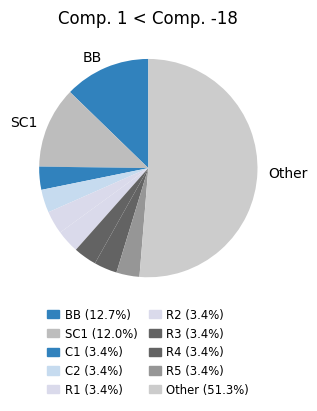

In [23]:
composition, fig, axs = cl.analyze_composition(containment, mode='names')

{1: {'AM2': 70158, 'BB': 857522, 'C1': 230093, 'C1A': 23386, 'C1A1': 66192, 'C1A2': 66192, 'C1B': 93544, 'C1B1': 66192, 'C1B2': 66192, 'C2': 230093, 'C2A': 70158, 'C2B': 85745, 'C3A': 93544, 'C3A1': 66192, 'C3A2': 66192, 'C3B': 93544, 'C3B1': 66192, 'C3B2': 66192, 'C4A': 93544, 'C4A1': 66192, 'C4A2': 66192, 'C4B': 93544, 'C4B1': 66192, 'C4B2': 66192, 'D2A': 23386, 'D2A1': 66192, 'D2A2': 66192, 'D2B': 7799, 'D2B1': 66192, 'D2B2': 66192, 'GL0': 7799, 'GL1': 23386, 'GL11': 66192, 'GL12': 66192, 'GL2': 23386, 'GL21': 66192, 'GL22': 66192, 'GLC': 66192, 'NC3': 85745, 'OH1': 70158, 'PO4': 93544, 'PO41': 66192, 'PO42': 66192, 'R1': 230093, 'R2': 230093, 'R3': 230093, 'R4': 230093, 'R5': 230093, 'R6': 230093, 'ROH': 230093, 'SC1': 810970, 'SC2': 201022, 'SC3': 98095, 'SC4': 40475, 'SC5': 9299, 'T1A': 70158}}


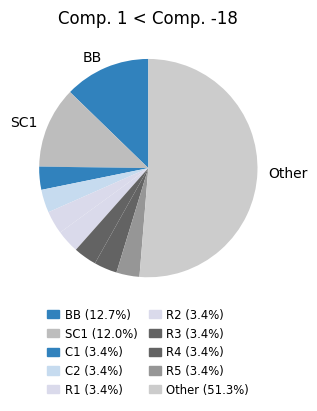

In [24]:
# We can also analyze the compositions of the filtered containment view
composition, fig, axs = cl.analyze_composition(containment_size_filtered, mode='names')

## Performing some hierarchical analysis
The goal is to select a random non_root and non-leaf container if there is one.
This is a rather arbitrary goal, but we hope it illustrates
how one can use a topological description to handle high
throughput data with noise. Quickly filtering interesting cases
which can be processed with more attention.

In [25]:
# Preparing the node sets for our selection
all_nodes = set(containment.voxel_containment.nodes)
root_nodes = set(containment.voxel_containment.root_nodes)
leaf_nodes = set(containment.voxel_containment.leaf_nodes)

# Select non-root and non-leaf nodes
container_nodes = list(all_nodes ^ (root_nodes | leaf_nodes))
# Shuffle the possible nodes for random selection
random.shuffle(container_nodes)
# Pick the first node in the shuffle list of possible container nodes
try:
    node = container_nodes[0]
    print(f'Selected non-root container: {node}')
except IndexError:
    print('No component satisfies the specified conditions.')

Selected non-root container: 1


In [26]:
# Get the atomgroup from the list of nodes.
visualize = False
if node is not None:
    container = containment.get_atomgroup_from_nodes([node], containment=True)
    print(f'Atomgroup with {len(container)} atoms.')
    # Write the atomgroup
    container.write('random_container.pdb')
    # Visualize with VMD
    if visualize:
        !{vmd} random_container.gro
else:
    raise ValueError('There are no non-root containers in the system.')

Atomgroup with 6733164 atoms.


### Plotting the composition of the container and its contents
#### Counting the resnames in the atomgroup.atoms

In [27]:
# Make another view to only get the nodes downstream of the selected node
containment_nonroot_container = containment.node_view([node])
nodes = [node]

{1: {'ALA': 97858, 'ARG': 62016, 'ASN': 114946, 'ASP': 77802, 'CHOL': 2070837, 'CYS': 8544, 'DOPG': 93588, 'GLN': 67778, 'GLU': 81960, 'GLY': 46552, 'HIS': 38400, 'ILE': 179328, 'LEU': 178496, 'LYS': 246765, 'MET': 34600, 'PHE': 192080, 'POPC': 187044, 'PRO': 47496, 'SER': 127558, 'SSM': 841896, 'THR': 100322, 'TOCL': 1522416, 'TRP': 55794, 'TYR': 155880, 'VAL': 103208}}


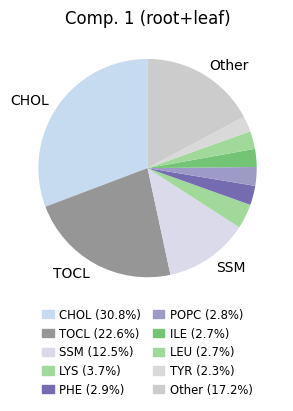

In [28]:
composition, fig, axs = cl.analyze_composition(containment_nonroot_container, mode='resnames')

#### Counting the names in the atomgroup.atoms

{1: {'AM2': 70158, 'BB': 857522, 'C1': 230093, 'C1A': 23386, 'C1A1': 66192, 'C1A2': 66192, 'C1B': 93544, 'C1B1': 66192, 'C1B2': 66192, 'C2': 230093, 'C2A': 70158, 'C2B': 85745, 'C3A': 93544, 'C3A1': 66192, 'C3A2': 66192, 'C3B': 93544, 'C3B1': 66192, 'C3B2': 66192, 'C4A': 93544, 'C4A1': 66192, 'C4A2': 66192, 'C4B': 93544, 'C4B1': 66192, 'C4B2': 66192, 'D2A': 23386, 'D2A1': 66192, 'D2A2': 66192, 'D2B': 7799, 'D2B1': 66192, 'D2B2': 66192, 'GL0': 7799, 'GL1': 23386, 'GL11': 66192, 'GL12': 66192, 'GL2': 23386, 'GL21': 66192, 'GL22': 66192, 'GLC': 66192, 'NC3': 85745, 'OH1': 70158, 'PO4': 93544, 'PO41': 66192, 'PO42': 66192, 'R1': 230093, 'R2': 230093, 'R3': 230093, 'R4': 230093, 'R5': 230093, 'R6': 230093, 'ROH': 230093, 'SC1': 810970, 'SC2': 201022, 'SC3': 98095, 'SC4': 40475, 'SC5': 9299, 'T1A': 70158}}


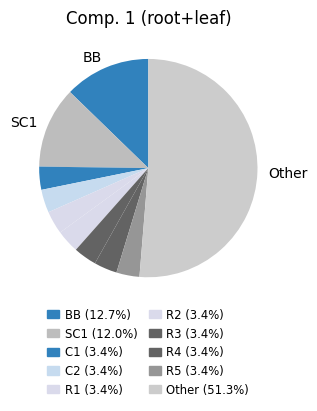

In [29]:
composition, fig, axs = cl.analyze_composition(containment_nonroot_container, mode='names')

## Demonstrating the power of views!
Views are a powerful way in which one can work with containment. You can make a view by using `(Voxel)Containment.node_view([nodes], min_size=0)`. A view will rebuild the non_label_contact_graph, component_contact_graph and containment_graph by merging all nodes not specified upstream. No copies of the memory intensive arrays are made, but they are indexed in a remapped fashion. This makes it easy for a user to work with a reduced version of the contact graph. 

Nearly all methods for the original (Voxel)Containment and their Views are identical, except for some very specific one such as: `VoxelContainmentView.get_original_nodes(self, view_node)` and `VoxelContainmentView.get_view_node(self, original_node)` which indicate which view nodes where mapped to which original nodes.

In [30]:
print(containment.get_atomgroup_from_nodes([node]).__repr__())
print(containment)

print(containment_nonroot_container.get_atomgroup_from_nodes([node]).__repr__())
print(containment_nonroot_container)

original_nodes = [int(sub_node) for sub_node in containment_nonroot_container.voxel_containment.get_original_nodes(node)]
print(f'Original nodes merged into node {node}: {original_nodes}')

<AtomGroup with 6733164 atoms>
Containment Graph with 19 components (component: nm³: rank):
└── [-18: 5289016: 3]
    └── [1: 649568: 0]
        ├── [-17: 6: 0]
        ├── [-16: 3024353: 0]
        ├── [-15: 3: 0]
        ├── [-14: 6: 0]
        ├── [-13: 10: 0]
        ├── [-12: 3: 0]
        ├── [-11: 6: 0]
        ├── [-10: 3: 0]
        ├── [-9: 3: 0]
        ├── [-8: 7: 0]
        ├── [-7: 3: 0]
        ├── [-6: 3: 0]
        ├── [-5: 3: 0]
        ├── [-4: 3: 0]
        ├── [-3: 6: 0]
        ├── [-2: 6: 0]
        └── [-1: 3: 0]

<AtomGroup with 6733164 atoms>
Containment Graph with 1 components (component: nm³: rank):
└── [1: 3674002: 0]

Original nodes merged into node 1: [1, -17, -16, -15, -14, -13, -12, -11, -2, -9, -8, -7, -6, -5, -4, -3, -1, -10]


In [31]:
# Show the interactive widget plotting
#cl.show_containment_with_composition(containment, max_display_items=1000, mode='resnames')

In [33]:
cl.get_compositions(containment)

{-18: {},
 -17: {},
 -16: {},
 -15: {},
 -14: {},
 -13: {},
 -12: {},
 -11: {},
 -10: {},
 -9: {},
 -8: {},
 -7: {},
 -6: {},
 -5: {},
 -4: {},
 -3: {},
 -2: {},
 -1: {},
 1: {'ALA': 97858,
  'ARG': 62016,
  'ASN': 114946,
  'ASP': 77802,
  'CHOL': 2070837,
  'CYS': 8544,
  'DOPG': 93588,
  'GLN': 67778,
  'GLU': 81960,
  'GLY': 46552,
  'HIS': 38400,
  'ILE': 179328,
  'LEU': 178496,
  'LYS': 246765,
  'MET': 34600,
  'PHE': 192080,
  'POPC': 187044,
  'PRO': 47496,
  'SER': 127558,
  'SSM': 841896,
  'THR': 100322,
  'TOCL': 1522416,
  'TRP': 55794,
  'TYR': 155880,
  'VAL': 103208}}